## **Análisis de Listados de Airbnb en Nueva York**

Data Science II - Comisión 67410

Carla Rejala Muniesa

**Motivación**: El mercado de alquileres vacacionales en Nueva York es altamente competitivo. Predecir el precio de los listings de Airbnb permite a los anfitriones optimizar sus tarifas y a las plataformas desarrollar estrategias de mercado basadas en datos.

**Audiencia**: Anfitriones de Airbnb, plataformas de alquiler vacacional y analistas de mercado inmobiliario.

**Problema**: Predecir el precio por noche de un listing de Airbnb (variable continua) utilizando características como ubicación, tipo de habitación, número de reseñas, noches mínimas, disponibilidad y antigüedad del listing. Este es un problema de **regresión**.

**Preguntas**:
1. ¿Qué características tienen mayor impacto en el precio de un listing?
2. ¿Podemos predecir con precisión el precio usando modelos de Machine Learning?
3. ¿Un modelo de ensemble (Random Forest o XGBoost) supera a un modelo lineal simple (Regresión Lineal)?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
import xgboost as xgb
import shap
import uuid


In [4]:
# Configuración inicial
plt.style.use('seaborn-v0_8')
%matplotlib inline
np.random.seed(42)

In [9]:
from google.colab import files
uploaded = files.upload()

Saving airbnb_nyc_2019.csv to airbnb_nyc_2019.csv


In [10]:
try:
    df = pd.read_csv('airbnb_nyc_2019.csv')
    print("Datos cargados exitosamente desde el archivo local.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    print("Asegúrate de que el archivo 'AB_NYC_2019.csv' esté en el mismo directorio que este notebook.")

print(df.head())

Datos cargados exitosamente desde el archivo local.
     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Privat

# Análisis Exploratorio de Datos (EDA)

In [11]:
## Resumen de metadatos
print("\nResumen de metadatos:")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print("\nTipos de variables:")
print(df.dtypes)
print("\nValores faltantes:")
print(df.isnull().sum())


Resumen de metadatos:
Número de filas: 48895
Número de columnas: 16

Tipos de variables:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Valores faltantes:
id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neig

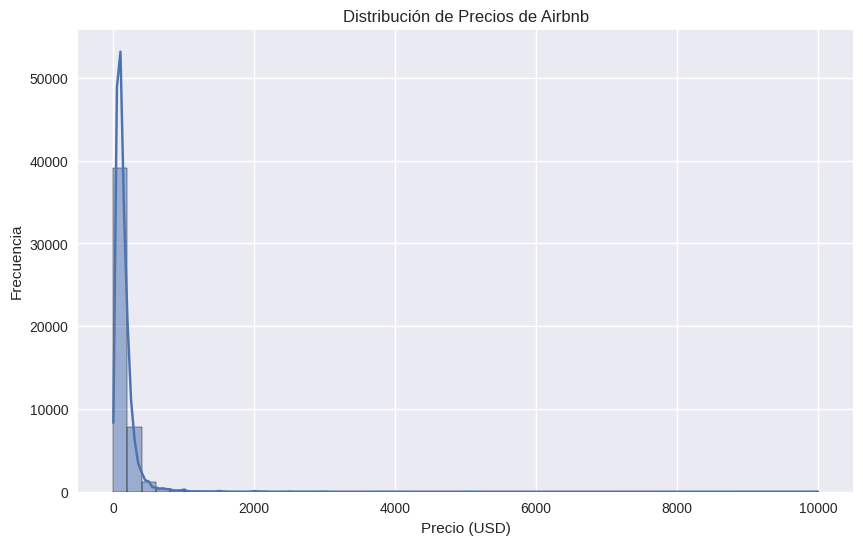

In [12]:
## Visualización 1: Distribución de precios
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribución de Precios de Airbnb')
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.savefig('price_distribution.png')
plt.show()

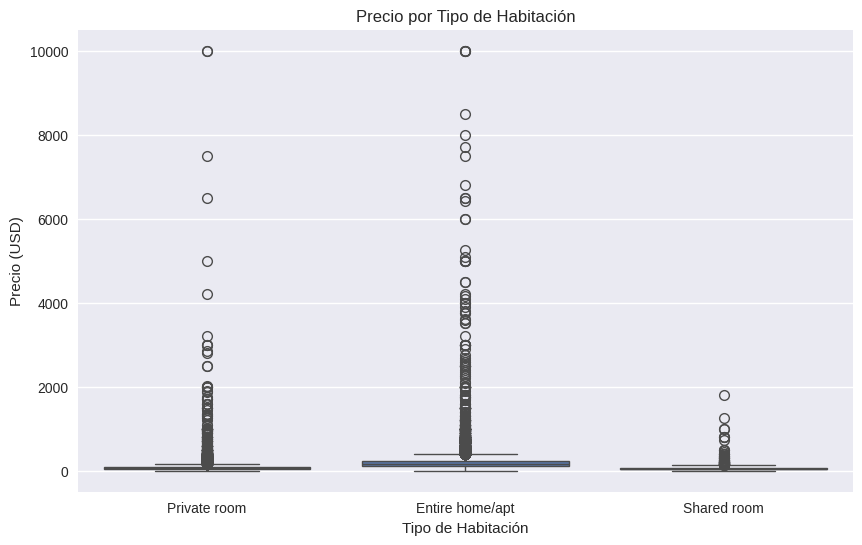

In [13]:
## Visualización 2: Precio por tipo de habitación
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Precio por Tipo de Habitación')
plt.xlabel('Tipo de Habitación')
plt.ylabel('Precio (USD)')
plt.savefig('price_by_room_type.png')
plt.show()

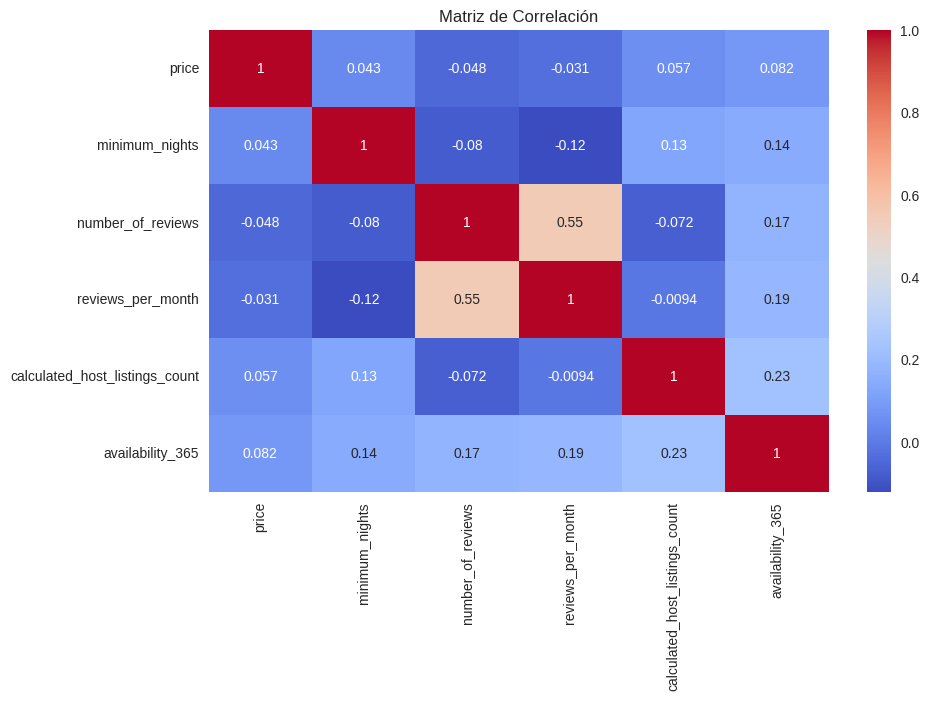

In [14]:
## Visualización 3: Correlación entre variables numéricas
numeric_cols = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.savefig('correlation_matrix.png')
plt.show()

## Limpieza de Datos

- Eliminamos outliers en el precio (manteniendo precios entre $10 y $1000).
- Imputamos valores faltantes en variables relevantes.

In [15]:
df = df[(df['price'] > 10) & (df['price'] < 1000)]
df['reviews_per_month'].fillna(0, inplace=True)
df['name'].fillna('Unknown', inplace=True)
df['host_name'].fillna('Unknown', inplace=True)
df['last_review'].fillna('No Reviews', inplace=True)

/tmp/ipython-input-1394548890.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_per_month'].fillna(0, inplace=True)
/tmp/ipython-input-1394548890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviews_per_month'].fillna(0, inplace=True)
/tmp/ipython-input-1394548890.py:3: FutureWarning: A value is trying to be set on a c

## Ingeniería de Atributos
- Creamos una nueva variable: antigüedad del listing (`listing_age`).
- Codificamos variables categóricas (`neighbourhood_group`, `room_type`) con OneHotEncoder.
- Estandarizamos variables numéricas con StandardScaler.

In [16]:
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['listing_age'] = (pd.to_datetime('2019-12-31') - df['last_review']).dt.days
df['listing_age'].fillna(df['listing_age'].median(), inplace=True)

/tmp/ipython-input-616308312.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['listing_age'].fillna(df['listing_age'].median(), inplace=True)


In [18]:
# Seleccionar características y target
features = ['neighbourhood_group', 'room_type', 'minimum_nights', 'number_of_reviews',
            'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'listing_age']
target = 'price'

In [19]:
# Dividir datos
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Preprocesamiento
numeric_features = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                    'calculated_host_listings_count', 'availability_365', 'listing_age']
categorical_features = ['neighbourhood_group', 'room_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

In [21]:
# Función para MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Entrenamiento de Modelos
Entrenamos tres modelos: Regresión Lineal, Random Forest y XGBoost.
Usamos validación cruzada (5-fold) para evaluar el RMSE en el conjunto de entrenamiento.

In [22]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
}

In [23]:
# Entrenamiento y evaluación
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Validación cruzada
    cv_scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-cv_scores)

    # Entrenar modelo
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Asegurar predicciones positivas para MSLE
    y_pred_adj = np.maximum(y_pred, 1e-10)

    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    median_ae = median_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    msle = mean_squared_log_error(y_test, y_pred_adj)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'CV RMSE': rmse_scores.mean(),
        'Test MSE': mse,
        'Test RMSE': rmse,
        'Test MAE': mae,
        'Test Median AE': median_ae,
        'Test MAPE': mape,
        'Test MSLE': msle,
        'Test R2': r2
    }

In [24]:
# Mostrar resultados
print("\nResultados de los modelos:")
results_df = pd.DataFrame(results).T
print(results_df)


Resultados de los modelos:
                     CV RMSE     Test MSE  Test RMSE   Test MAE  \
Linear Regression  93.602712  8891.613147  94.295351  56.437423   
Random Forest      90.592919  8389.475511  91.594080  54.262347   
XGBoost            88.424988  7967.305664  89.259765  52.760372   

                   Test Median AE  Test MAPE  Test MSLE   Test R2  
Linear Regression       37.552673  45.857197   0.278829  0.308850  
Random Forest           31.890896  43.301679   0.223624  0.347882  
XGBoost                 31.436375  42.107267   0.225215  0.380697  


## Optimización de Hiperparámetros
Optimizamos el modelo XGBoost usando GridSearchCV para encontrar los mejores hiperparámetros.

In [25]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1]
}

In [26]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))
])

In [27]:
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['minimum_nights',
                                                                          'number_of_reviews',
                                                                          'reviews_per_month',
                                                                          'calculated_host_listings_count',
                                                                          'availability_365',
                                                                          'listing_age']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['neighbourhood_group',
                                                                          'room_type'])])),
                                       ('model',...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [28]:
# Mejor modelo
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_pred_best_adj = np.maximum(y_pred_best, 1e-10)

In [29]:
# Calcular métricas para el mejor modelo
best_mse = mean_squared_error(y_test, y_pred_best)
best_rmse = np.sqrt(best_mse)
best_mae = mean_absolute_error(y_test, y_pred_best)
best_median_ae = median_absolute_error(y_test, y_pred_best)
best_mape = mean_absolute_percentage_error(y_test, y_pred_best)
best_msle = mean_squared_log_error(y_test, y_pred_best_adj)
best_r2 = r2_score(y_test, y_pred_best)

print("\nMejor modelo (XGBoost optimizado):")
print(f"Parámetros: {grid_search.best_params_}")
print(f"Test MSE: {best_mse:.2f}")
print(f"Test RMSE: {best_rmse:.2f}")
print(f"Test MAE: {best_mae:.2f}")
print(f"Test Median AE: {best_median_ae:.2f}")
print(f"Test MAPE: {best_mape:.2f}%")
print(f"Test MSLE: {best_msle:.4f}")
print(f"Test R2: {best_r2:.2f}")


Mejor modelo (XGBoost optimizado):
Parámetros: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Test MSE: 7740.94
Test RMSE: 87.98
Test MAE: 51.56
Test Median AE: 30.87
Test MAPE: 40.72%
Test MSLE: 0.2046
Test R2: 0.40


## Interpretación con SHAP
Analizamos la importancia de las características usando SHAP para entender qué variables influyen más en las predicciones.

 99%|===================| 9648/9714 [01:00<00:00]       /tmp/ipython-input-1795182671.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_processed, feature_names=best_model.named_steps['preprocessor'].get_feature_names_out())


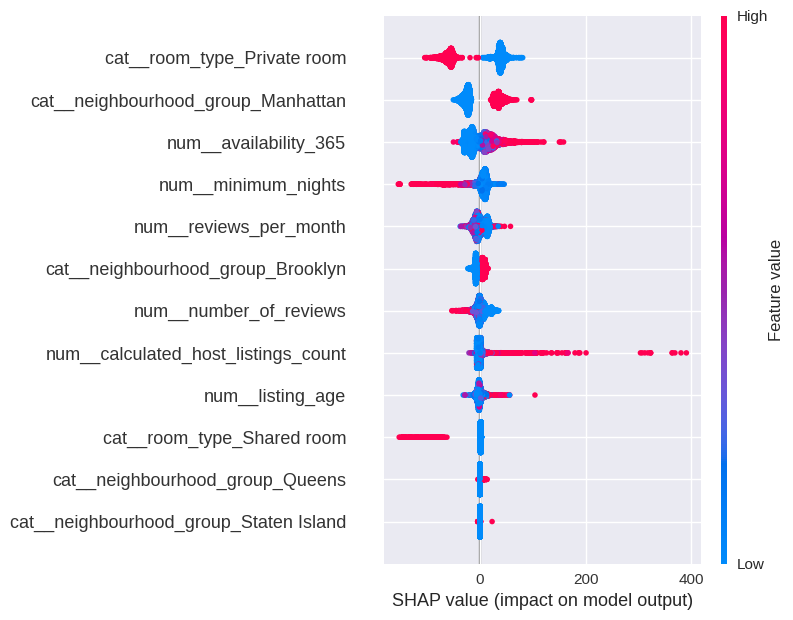

<Figure size 800x550 with 0 Axes>

In [33]:
X_test_processed = best_model.named_steps['preprocessor'].transform(X_test)

explainer = shap.Explainer(best_model.named_steps['model'], X_test_processed)
shap_values = explainer(X_test_processed)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_processed, feature_names=best_model.named_steps['preprocessor'].get_feature_names_out())
plt.savefig('shap_summary.png')
plt.show()

## Conclusiones
- **Hallazgos**:
  1. Las características más influyentes son el tipo de habitación (Entire home/apt vs. Private room) y el vecindario (Manhattan es más caro).
  2. El modelo XGBoost optimizado logra el mejor rendimiento en todas las métricas.
  3. Variables como antigüedad del listing y disponibilidad tienen un impacto moderado.
  4. Los modelos de ensemble (Random Forest, XGBoost) superan a la Regresión Lineal.

- **Recomendaciones**:
  1. Los anfitriones deben fijar precios más altos para apartamentos completos en Manhattan.
  2. Optimizar la disponibilidad para maximizar ingresos.
  3. Usar modelos de ensemble como XGBoost para predicciones precisas.
"""